### HEALTH EQUITY INDICATORS; SAN FRANCISCO, CA 2020 ###

In this notebook, I will combine the data I have collected and analyzed thus far on COVID-19 burden and access to health insurance in San Francisco. I am going to add information on hospital locations in the city and look at the proximity of hospitals to the neighborhoods that are most affected by COVID-19. 

#### IMPORTING DATA ####

In [71]:
#importing libraries
import pandas as pd
import geopandas as gpd
import plotly.express as px

First, I am going to pull in data that will connect the census tracts with actual recognized neighborhoods in San Francisco so that we can look specifically at our area of focus, Bayview-Hunters Point.

In [72]:
#pull in the Analysis Neighborhoods data set from DataSF
nb = gpd.read_file('data/SF2020_Neighborhoods_CTs.geojson')

In [73]:
nb.shape

(242, 12)

It looks like there are 242 census tracts which aligns with the data sets I have been working with.

In [74]:
nb.head(5)

,name,neighborhoods_analysis_boundaries,tractce,sup_dist_2022,data_loaded_at,county_fp,state_fp,sup_dist_2012,data_as_of,object_id,geoid,geometry
0,9809,Bayview Hunters Point,980900,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,242,06075980900,"MULTIPOLYGON (((-122.37276 37.74551, -122.3727..."
1,9806,Bayview Hunters Point,980600,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,241,06075980600,"MULTIPOLYGON (((-122.36519 37.73373, -122.3665..."
2,9805.01,McLaren Park,980501,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,240,06075980501,"MULTIPOLYGON (((-122.40667 37.71921, -122.4069..."
3,9804.01,The Farallones,980401,4,2022-07-08 14:12:00,075,06,1,2022-07-08 21:09:48.141,239,06075980401,"MULTIPOLYGON (((-123.00360 37.69325, -123.0040..."
4,612,Bayview Hunters Point,061200,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,226,06075061200,"MULTIPOLYGON (((-122.38528 37.74024, -122.3858..."


I will now clean up this data a bit and drop some of the census tracts that correspond to islands with no residents.

In [75]:
#dropping the Farrollones census tract because it has messed with our maps in the past
nb = nb.drop(labels=3, axis=0)

In [76]:
nb.shape

(241, 12)

Ok, it appears the tract was dropped!

In [77]:
#renaming the six columns
nb.columns = ['Name',
              'Neighborhood', 
              'Census Tract',
              'Supervisor District 2022',
              'Data Loaded',
              'County Code',
              'State Code',
              'Supervisor District 2012',
              'Data as of',
              'Object ID',
              'FIPS',
              'Geometry',]

In [78]:
#checking that the above function worked
nb.head()

,Name,Neighborhood,Census Tract,Supervisor District 2022,Data Loaded,County Code,State Code,Supervisor District 2012,Data as of,Object ID,FIPS,Geometry
0,9809,Bayview Hunters Point,980900,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,242,06075980900,"MULTIPOLYGON (((-122.37276 37.74551, -122.3727..."
1,9806,Bayview Hunters Point,980600,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,241,06075980600,"MULTIPOLYGON (((-122.36519 37.73373, -122.3665..."
2,9805.01,McLaren Park,980501,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,240,06075980501,"MULTIPOLYGON (((-122.40667 37.71921, -122.4069..."
4,612,Bayview Hunters Point,061200,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,226,06075061200,"MULTIPOLYGON (((-122.38528 37.74024, -122.3858..."
5,611.02,Chinatown,061102,3,2022-07-08 14:12:00,075,06,3,2022-07-08 21:09:48.141,225,06075061102,"MULTIPOLYGON (((-122.40631 37.79426, -122.4068..."


In [79]:
# getting a count on how many census tracts are in each neighborhood
nb['Neighborhood'].value_counts()

Mission                           17
Sunset/Parkside                   16
Tenderloin                        12
Outer Richmond                    11
Bayview Hunters Point             11
Financial District/South Beach    10
Marina                             9
Nob Hill                           9
Pacific Heights                    9
Excelsior                          8
Castro/Upper Market                7
Western Addition                   7
West of Twin Peaks                 7
South of Market                    7
Russian Hill                       7
Noe Valley                         6
Bernal Heights                     6
Oceanview/Merced/Ingleside         6
Inner Sunset                       6
Chinatown                          6
Haight Ashbury                     5
Hayes Valley                       5
Outer Mission                      5
North Beach                        5
Potrero Hill                       5
Inner Richmond                     5
Visitacion Valley                  5
P

Great, I am excited to see how this overlays with the health indicator data!

But before that happend, I need to join this data with the spatial data from 2020 census tracts. Then, I will start to map.

In [80]:
# bring in the geojson file with census tracts
tracts=gpd.read_file('data/2020CTs.geojson')
# see what the data looks like
tracts.head()

,name,intptlon,awater,mtfcc,aland,namelsad,tractce,statefp,data_loaded_at,intptlat,funcstat,countyfp,data_as_of,geoid,geometry
0,9805.01,-122.4193463,9769.0,G5020,1471536.0,Census Tract 9805.01,980501,06,2022-03-04,+37.7162081,S,075,2021-02-01,06075980501,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271..."
1,171.02,-122.4504754,0.0,G5020,294894.0,Census Tract 171.02,017102,06,2022-03-04,+37.7654353,S,075,2021-02-01,06075017102,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516..."
2,123.02,-122.4120970,0.0,G5020,92653.0,Census Tract 123.02,012302,06,2022-03-04,+37.7870222,S,075,2021-02-01,06075012302,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133..."
3,168.01,-122.4290133,0.0,G5020,226534.0,Census Tract 168.01,016801,06,2022-03-04,+37.7713309,S,075,2021-02-01,06075016801,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308..."
4,119.02,-122.4098067,0.0,G5020,93053.0,Census Tract 119.02,011902,06,2022-03-04,+37.7909959,S,075,2021-02-01,06075011902,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117..."


In [81]:
#seeing how many rows and columns we're working with 
tracts.shape

(244, 15)

This is almost a match with the 241 tracts from the neighborhood data set. But I will pull a bit more info before merging this with the neighborhood data.

In [82]:
tracts.info(5)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            244 non-null    object        
 1   intptlon        244 non-null    object        
 2   awater          244 non-null    object        
 3   mtfcc           244 non-null    object        
 4   aland           244 non-null    object        
 5   namelsad        244 non-null    object        
 6   tractce         244 non-null    object        
 7   statefp         244 non-null    object        
 8   data_loaded_at  244 non-null    datetime64[ns]
 9   intptlat        244 non-null    object        
 10  funcstat        244 non-null    object        
 11  countyfp        244 non-null    object        
 12  data_as_of      244 non-null    datetime64[ns]
 13  geoid           244 non-null    object        
 14  geometry        244 non-null    geometry      
dty

Based on this list of columns, we really only need the census tract number (tractce10) and geometry columns in order to merge the two data sets. Let's move forward with doing so.

In [83]:
tracts = tracts[['tractce','geometry']]
tracts.head()

,tractce,geometry
0,980501,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271..."
1,017102,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516..."
2,012302,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133..."
3,016801,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308..."
4,011902,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117..."


We have the census tract number, but we need a full FIPS code to merge. We'll add '06' for the state of California and '075' for the county of San Francisco to the census tract number as follows.

In [84]:
# create a FIPS column before merging
tracts['FIPS'] ='06' + '075' + tracts['tractce']

In [85]:
# double check that we have a new and complete FIPS code column
tracts.head()

,tractce,geometry,FIPS
0,980501,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271...",06075980501
1,017102,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516...",06075017102
2,012302,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",06075012302
3,016801,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308...",06075016801
4,011902,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117...",06075011902


Great, that worked! Now the FIPS codes will match the structure of the FIPS codes from the other data set which will make it possible to merge the two files.

In [86]:
# create a new dataframe based on the join, tracts is spatial data so must come first
nhoods=tracts.merge(nb,on="FIPS")

In [87]:
nhoods.head(5)

,tractce,geometry,FIPS,Name,Neighborhood,Census Tract,Supervisor District 2022,Data Loaded,County Code,State Code,Supervisor District 2012,Data as of,Object ID,Geometry
0,980501,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271...",06075980501,9805.01,McLaren Park,980501,10,2022-07-08 14:12:00,075,06,10,2022-07-08 21:09:48.141,240,"MULTIPOLYGON (((-122.40667 37.71921, -122.4069..."
1,017102,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516...",06075017102,171.02,Haight Ashbury,017102,8,2022-07-08 14:12:00,075,06,5,2022-07-08 21:09:48.141,84,"MULTIPOLYGON (((-122.44912 37.76165, -122.4505..."
2,012302,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",06075012302,123.02,Tenderloin,012302,3,2022-07-08 14:12:00,075,06,3,2022-07-08 21:09:48.141,32,"MULTIPOLYGON (((-122.40823 37.78736, -122.4098..."
3,016801,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308...",06075016801,168.01,Hayes Valley,016801,5,2022-07-08 14:12:00,075,06,5,2022-07-08 21:09:48.141,79,"MULTIPOLYGON (((-122.42493 37.77078, -122.4264..."
4,011902,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117...",06075011902,119.02,Nob Hill,011902,3,2022-07-08 14:12:00,075,06,3,2022-07-08 21:09:48.141,24,"MULTIPOLYGON (((-122.40879 37.79016, -122.4104..."


In [88]:
# define the columns to keep, which include: geometry, FIPS and Neighborhood
columns_to_keep = ['geometry',
                   'FIPS',
                   'Neighborhood']

In [89]:
# copy and create a new function, nhoods2, that just displays the defined columns to keep
nhoods2 = nhoods[columns_to_keep].copy()
nhoods2

,geometry,FIPS,Neighborhood
0,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271...",06075980501,McLaren Park
1,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516...",06075017102,Haight Ashbury
2,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",06075012302,Tenderloin
3,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308...",06075016801,Hayes Valley
4,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117...",06075011902,Nob Hill
...,...,...,...
236,"MULTIPOLYGON (((-122.42646 37.76627, -122.4252...",06075020201,Mission
237,"MULTIPOLYGON (((-122.39362 37.78308, -122.3928...",06075061508,Financial District/South Beach
238,"MULTIPOLYGON (((-122.43075 37.79865, -122.4291...",06075013001,Marina
239,"MULTIPOLYGON (((-122.42484 37.80227, -122.4246...",06075010201,Russian Hill


This is exactly what we need in order to start mapping our neighborhoods of census tracts! In the next section, I will import the COVID-19 data and then the health insurance data and then map it over the neighborhoods. But first, I want to see what the neighborhoods look like mapped out!

<AxesSubplot: >

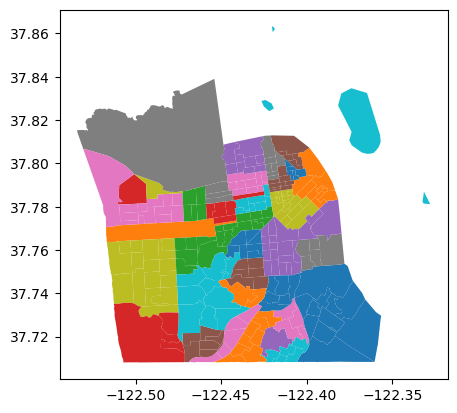

In [90]:
#simple plot map with colors
nhoods.plot(column='Neighborhood')

### COVID-19 DATA ###

In [130]:
# import the data and create it as a new variable
COVIDdf = pd.read_csv('data/COVID 19 SF.csv')

In [131]:
COVIDdf.info

<bound method DataFrame.info of         area_type        FIPS  acs_population  count  count_last_60_days  \
0    Census Tract  6075010101            2045    360                  13   
1    Census Tract  6075010102            1920    374                  15   
2    Census Tract  6075010201            2331    384                  10   
3    Census Tract  6075010202            1984    352                   6   
4    Census Tract  6075010300            4282    657                  16   
..            ...         ...             ...    ...                 ...   
235  Census Tract  6075061508            2302    471                  16   
236  Census Tract  6075980300              32     10                   0   
237  Census Tract  6075980501             153     17                   2   
238  Census Tract  6075980600             747    362                  18   
239  Census Tract  6075980900             242    245                   7   

             rate  deaths                              

Great news, there are 240 rows AKA 240 census tracts. This almost matches the neighborhood data!

In [132]:
COVIDdf.head(5)

,area_type,FIPS,acs_population,count,count_last_60_days,rate,deaths,multipolygon
0,Census Tract,6075010101,2045,360,13,1760.391198,3,MULTIPOLYGON (((-122.4210759996576 37.81288900...
1,Census Tract,6075010102,1920,374,15,1947.916667,0,MULTIPOLYGON (((-122.41688799988128 37.8052120...
2,Census Tract,6075010201,2331,384,10,1647.361647,3,MULTIPOLYGON (((-122.42483500033495 37.8022680...
3,Census Tract,6075010202,1984,352,6,1774.193548,2,MULTIPOLYGON (((-122.42684799963547 37.8090189...
4,Census Tract,6075010300,4282,657,16,1534.329752,2,MULTIPOLYGON (((-122.41871799973586 37.8059320...


In [133]:
#adding back in leading zeros
COVIDdf = pd.read_csv(
    'data/COVID 19 SF.csv',
    dtype=
    {
        'FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
    
)

In [134]:
COVIDdf.head(5)

,area_type,FIPS,acs_population,count,count_last_60_days,rate,deaths,multipolygon
0,Census Tract,06075010101,2045,360,13,1760.391198,3,MULTIPOLYGON (((-122.4210759996576 37.81288900...
1,Census Tract,06075010102,1920,374,15,1947.916667,0,MULTIPOLYGON (((-122.41688799988128 37.8052120...
2,Census Tract,06075010201,2331,384,10,1647.361647,3,MULTIPOLYGON (((-122.42483500033495 37.8022680...
3,Census Tract,06075010202,1984,352,6,1774.193548,2,MULTIPOLYGON (((-122.42684799963547 37.8090189...
4,Census Tract,06075010300,4282,657,16,1534.329752,2,MULTIPOLYGON (((-122.41871799973586 37.8059320...


In [156]:
# renaming the column so that when I graph, the axis title is capitalized
COVIDdf = COVIDdf.rename(columns={'rate': 'Rate'})

In [136]:
COVIDdf.head(5)

,area_type,FIPS,acs_population,count,count_last_60_days,Rate,deaths,multipolygon
0,Census Tract,06075010101,2045,360,13,1760.391198,3,MULTIPOLYGON (((-122.4210759996576 37.81288900...
1,Census Tract,06075010102,1920,374,15,1947.916667,0,MULTIPOLYGON (((-122.41688799988128 37.8052120...
2,Census Tract,06075010201,2331,384,10,1647.361647,3,MULTIPOLYGON (((-122.42483500033495 37.8022680...
3,Census Tract,06075010202,1984,352,6,1774.193548,2,MULTIPOLYGON (((-122.42684799963547 37.8090189...
4,Census Tract,06075010300,4282,657,16,1534.329752,2,MULTIPOLYGON (((-122.41871799973586 37.8059320...


Now I will make a bar chart that shows the 5 census tracts in SF with the highest rate of COVID-19 cases and highest number of COVID-19 deaths.

In [137]:
COVIDdf2=COVIDdf.sort_values(by='Rate',ascending = False)

<AxesSubplot: title={'center': 'Top 5 Census Tracts in SF with Highest Rate of COVID-19 Cases'}, ylabel='FIPS'>

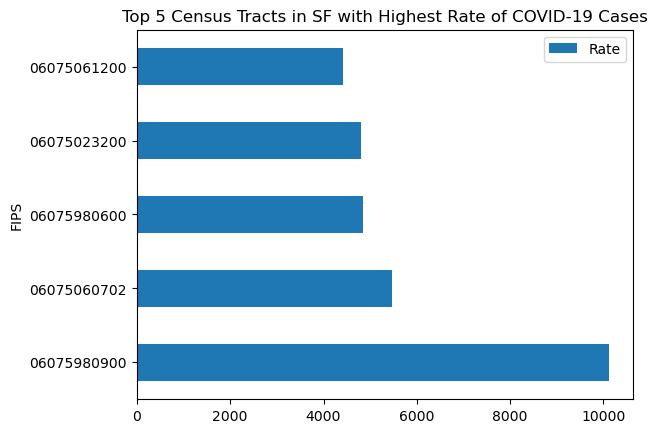

In [138]:
COVIDdf2.head(5).plot.barh(x='FIPS',
    y='Rate', 
    title='Top 5 Census Tracts in SF with Highest Rate of COVID-19 Cases')

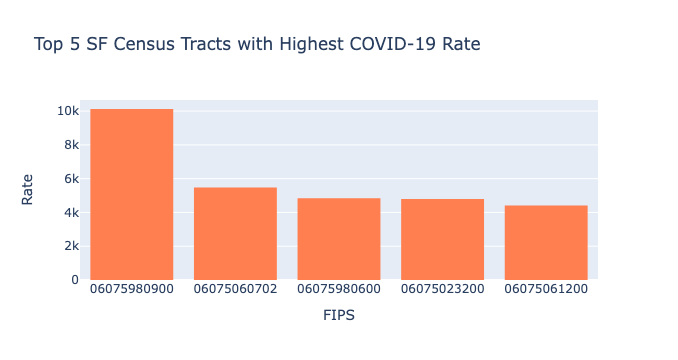

In [139]:
# creating an interactive bar chart

COVIDdf2=COVIDdf.sort_values(by='Rate',ascending = False)

fig=px.bar(COVIDdf2.head(5),
           x='FIPS',
           y='Rate',
           title='Top 5 SF Census Tracts with Highest COVID-19 Rate'
          )
fig.update_traces(marker_line_width=0, marker_color='coral')
           
fig.show()

In [140]:
fig.write_html('COVID-19_Graph.html')

In [141]:
COVIDdf=COVIDdf.sort_values(by='deaths',ascending = False)

<AxesSubplot: title={'center': 'Top 5 Census Tracts in SF with Highest Number of COVID-19 Deaths'}, ylabel='FIPS'>

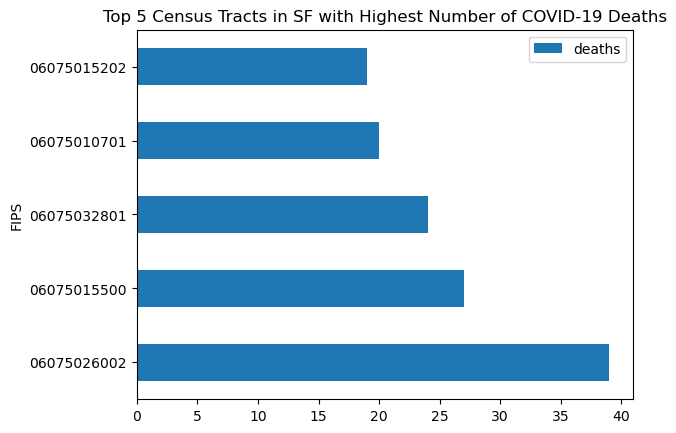

In [142]:
# creating a bar chart
COVIDdf.head(5).plot.barh(x='FIPS',
    y='deaths', 
    title='Top 5 Census Tracts in SF with Highest Number of COVID-19 Deaths')

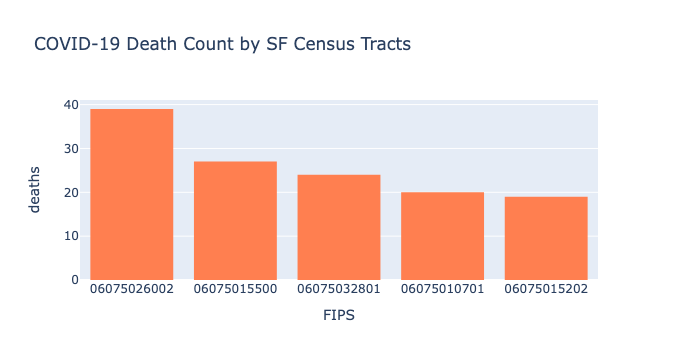

In [143]:
# creating an interactive bar chart for COVID death count by census tract
COVIDdf=COVIDdf.sort_values(by='deaths',ascending = False)

fig=px.bar(COVIDdf.head(5),
           x='FIPS',
           y='deaths',
           title='COVID-19 Death Count by SF Census Tracts'
          )
fig.update_traces(marker_line_width=0, marker_color='coral')
           
fig.show()

In [145]:
# merge the data sets for mapping
tracts_COVID=nhoods2.merge(COVIDdf,on="FIPS")

In [147]:
# making sure that worked
tracts_COVID.head(5)

,geometry,FIPS,Neighborhood,area_type,acs_population,count,count_last_60_days,Rate,deaths,multipolygon
0,"MULTIPOLYGON (((-122.42722 37.71555, -122.4271...",06075980501,McLaren Park,Census Tract,153,17,2,1111.111111,1,MULTIPOLYGON (((-122.42722299984155 37.7155489...
1,"MULTIPOLYGON (((-122.45321 37.76825, -122.4516...",06075017102,Haight Ashbury,Census Tract,3893,625,27,1605.445672,0,MULTIPOLYGON (((-122.45320600015674 37.7682489...
2,"MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",06075012302,Tenderloin,Census Tract,2656,620,13,2334.337349,6,MULTIPOLYGON (((-122.41499499981933 37.7874539...
3,"MULTIPOLYGON (((-122.43235 37.77378, -122.4308...",06075016801,Hayes Valley,Census Tract,4087,900,28,2202.104233,3,MULTIPOLYGON (((-122.43235099979876 37.7737789...
4,"MULTIPOLYGON (((-122.41246 37.79163, -122.4117...",06075011902,Nob Hill,Census Tract,2957,463,14,1565.776124,3,MULTIPOLYGON (((-122.41246099987524 37.7916269...


### MAPPING ###

In [148]:
import folium

In [149]:
# mapping COVID deaths by census tract and neighborhood
tracts_COVID.explore(
    column="deaths",
    tooltip="Neighborhood",
    popup=True,
    tiles="cartodbpositron",
    cmap="Reds",
    style_kwds=dict(color="white", weight=".3")
 )

In [150]:
# mapping COVID rate by census tract and neighborhood
tracts_COVID.explore(
    column="Rate",
    tooltip="Neighborhood",
    popup=True,
    tiles="cartodbpositron",
    cmap="Blues",
    style_kwds=dict(color="white", weight=".3")
 )

### HEALTH INSURANCE DATA ###

In [157]:
# importing health insurance coverage data
HIdf = pd.read_csv('data/Health Insurance Data.csv')

In [158]:
HIdf.shape

(243, 22)

In [159]:
HIdf.head(5)

,FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_STATE,Geo_COUNTY,Geo_TRACT,...,Geo_BTTR,Total,No Health Insurance,With Health Insurance,Public Health Insurance,Private Health Insurance,Percent No Health Insurance,Percent With Health Insurance,Percent Public Health Insurance,Percent Private Health Insurance
0,6075010101,"Census Tract 101.01, San Francisco County, Cal...",ACSSF,ca,140,0,9875,6,75,10101,...,NaN,2118,129,1989,551,1550,6.09,93.91,26.02,73.18
1,6075010102,"Census Tract 101.02, San Francisco County, Cal...",ACSSF,ca,140,0,9876,6,75,10102,...,NaN,1783,0,1783,1045,932,0.00,100.00,58.61,52.27
2,6075010201,"Census Tract 102.01, San Francisco County, Cal...",ACSSF,ca,140,0,9877,6,75,10201,...,NaN,2499,29,2470,474,2361,1.16,98.84,18.97,94.48
3,6075010202,"Census Tract 102.02, San Francisco County, Cal...",ACSSF,ca,140,0,9878,6,75,10202,...,NaN,1891,0,1891,417,1681,0.00,100.00,22.05,88.89
4,6075010300,"Census Tract 103, San Francisco County, Califo...",ACSSF,ca,140,0,9879,6,75,10300,...,NaN,3996,53,3943,1096,3314,1.33,98.67,27.43,82.93


I am now going to add back in the leading zeros to the FIPS codes so that they match with the other data sets I want to merge with. 

In [162]:
# add in leading zeros
HIdf = pd.read_csv(
    'data/Health Insurance Data.csv',
    dtype=
    {
        'FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
    
)

In [163]:
# checking to make sure that worked
HIdf.head(5)

,FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_STATE,Geo_COUNTY,Geo_TRACT,...,Geo_BTTR,Total,No Health Insurance,With Health Insurance,Public Health Insurance,Private Health Insurance,Percent No Health Insurance,Percent With Health Insurance,Percent Public Health Insurance,Percent Private Health Insurance
0,06075010101,"Census Tract 101.01, San Francisco County, Cal...",ACSSF,ca,140,0,9875,6,75,10101,...,NaN,2118,129,1989,551,1550,6.09,93.91,26.02,73.18
1,06075010102,"Census Tract 101.02, San Francisco County, Cal...",ACSSF,ca,140,0,9876,6,75,10102,...,NaN,1783,0,1783,1045,932,0.00,100.00,58.61,52.27
2,06075010201,"Census Tract 102.01, San Francisco County, Cal...",ACSSF,ca,140,0,9877,6,75,10201,...,NaN,2499,29,2470,474,2361,1.16,98.84,18.97,94.48
3,06075010202,"Census Tract 102.02, San Francisco County, Cal...",ACSSF,ca,140,0,9878,6,75,10202,...,NaN,1891,0,1891,417,1681,0.00,100.00,22.05,88.89
4,06075010300,"Census Tract 103, San Francisco County, Califo...",ACSSF,ca,140,0,9879,6,75,10300,...,NaN,3996,53,3943,1096,3314,1.33,98.67,27.43,82.93


Now I will go ahead and identify which columns I want to keep. For this data set, I am keeping information on the total number of people, how many have health insurance, how many do not, and if it is private or public insurance. I am also keeping the columns with the percent calculation for each category I am keeping because this is the data I will map.

In [164]:
columns_to_keep = ['FIPS',
                   'No Health Insurance', 
                   'With Health Insurance',
                   'Public Health Insurance',
                   'Private Health Insurance',
                   'Percent No Health Insurance',
                   'Percent With Health Insurance',
                   'Percent Public Health Insurance',
                   'Percent Private Health Insurance']
HIdf2 = HIdf[columns_to_keep]

In [165]:
# taking a sample to make sure that the columns were saved correctly
HIdf2.head(10)

,FIPS,No Health Insurance,With Health Insurance,Public Health Insurance,Private Health Insurance,Percent No Health Insurance,Percent With Health Insurance,Percent Public Health Insurance,Percent Private Health Insurance
0,06075010101,129,1989,551,1550,6.09,93.91,26.02,73.18
1,06075010102,0,1783,1045,932,0.00,100.00,58.61,52.27
2,06075010201,29,2470,474,2361,1.16,98.84,18.97,94.48
3,06075010202,0,1891,417,1681,0.00,100.00,22.05,88.89
4,06075010300,53,3943,1096,3314,1.33,98.67,27.43,82.93
5,06075010401,11,2191,373,1999,0.50,99.50,16.94,90.78
6,06075010402,149,2143,545,1775,6.50,93.50,23.78,77.44
7,06075010500,102,3328,1471,2313,2.97,97.03,42.89,67.43
8,06075010600,198,3079,1179,2165,6.04,93.96,35.98,66.07
9,06075010701,100,3358,2481,1025,2.89,97.11,71.75,29.64


In [45]:
# what is the average number of people with health insurance per census tract?
HIdf2['With Health Insurance'].mean()

3418.5185185185187

In [46]:
# what is the average number of people without health insurance per census tract?
HIdf2['No Health Insurance'].mean()

128.10699588477365

In [47]:
# what is the average number of people with public health coverage per census tract?
HIdf2['Public Health Insurance'].mean()

1046.0

I am now going to look for which census tracts have the highest number of publicly insured individuals. I am using this data point instead of uninsured because many people in California are insured due to Covered CA. We can also see above that the average number of people without health insurance per census tract is much lower when comparing to people with insurance and with public insurance.

In [166]:
# sorting the census tracts by number of residents with public health coverage
HIdf_sorted = HIdf2.sort_values(by='Percent Public Health Insurance',ascending = False)

In [167]:
# looking at the top 5 census tracts for health insurance coverage
HIdf_sorted[['FIPS','Percent Public Health Insurance']].head(5)

,FIPS,Percent Public Health Insurance
38,06075012504,77.80
9,06075010701,71.75
224,06075061102,71.72
36,06075012502,67.88
223,06075061101,66.92


<AxesSubplot: xlabel='FIPS'>

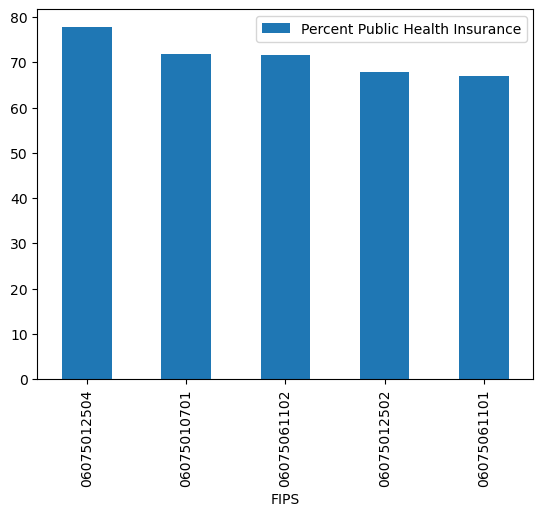

In [168]:
HIdf_sorted.head(5).plot.bar(x='FIPS',
                            y='Percent Public Health Insurance')

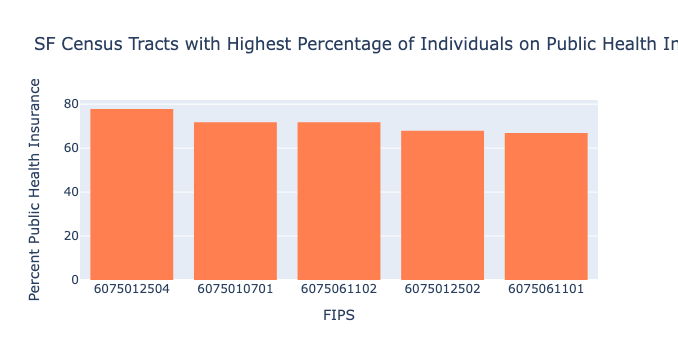

In [51]:
# creating an interactive bar chart for public health insurance coverage by census tract
HIdf_sorted[['FIPS','Percent Public Health Insurance']].head(5)

fig=px.bar(HIdf_sorted.head(5),
           x='FIPS',
           y='Percent Public Health Insurance',
           title='SF Census Tracts with Highest Percentage of Individuals on Public Health Insurance'
          )
fig.update_traces(marker_line_width=0, marker_color='coral')
           
fig.show()

This is interesting, many of these tracts correspond to China Town and Japan Town. These neighborhoods have a larger portion of elderly adults which makes sense why they have a large portion of individuals on public insurance programs.

Since our project is mostly concerned with Bayview-Hunter's Point, I am now going to upload another csv file that only contains information about this neighborhood so we can get a better picture of what is going on there.

In [171]:
# importing public health insurance coverage data for Bayview/Hunters Point
HPBV = pd.read_csv('data/HPBV Public Health Coverage.csv')

In [172]:
HPBV.head()

,FIPS,Percent Covered
0,6075980900,26
1,6075980600,30
2,6075023200,40
3,6075061000,33
4,6075023103,65


In [173]:
HPBV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   FIPS             11 non-null     int64
 1   Percent Covered  11 non-null     int64
dtypes: int64(2)
memory usage: 304.0 bytes


In [174]:
# changing the FIPS column to string so that it is not read as a number
HPBV.FIPS = HPBV.FIPS.astype('Int64').astype(str) 

In [175]:
HPBV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FIPS             11 non-null     object
 1   Percent Covered  11 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [176]:
HPBV.head(5)

,FIPS,Percent Covered
0,6075980900,26
1,6075980600,30
2,6075023200,40
3,6075061000,33
4,6075023103,65


In [177]:
HPBV_sorted = HPBV.sort_values(by='Percent Covered',ascending = False)

In [178]:
HPBV_sorted.head()

,FIPS,Percent Covered
4,6075023103,65
5,6075023102,60
7,6075023300,50
9,6075023400,48
6,6075061200,43


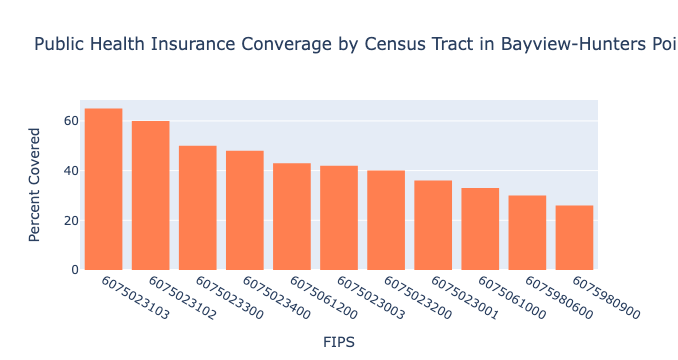

In [179]:
# creating an interactive bar chart for public health insurance coverage in Bayview/Hunters Point
HPBV_sorted[['FIPS','Percent Covered']].head(5)

fig=px.bar(HPBV_sorted.head(11),
           x='FIPS',
           y='Percent Covered',
           title='Public Health Insurance Converage by Census Tract in Bayview-Hunters Point'
          )
fig.update_traces(marker_line_width=0, marker_color='coral')
           
fig.show()

Over half of the 11 census tracts that correspond to the Bayview-Hunter's Point neighborhood have over 40% of people covered by public health insurance. 4/10 Californias are covered by a public program so this is interesting but not surprising that this neighborhood is above average in this scenario.

In [181]:
fig.write_html('HPBV_Insurance.html')

### HOSPITALS IN SAN FRANCISCO ###

I am now going to import a new data set that I have not analyzed thus far. This is a data set that has information on where hospitals are in San Francisco. We will use this information to see if there are areas of the city that do not have easy access to emergency health care facilities.

In [182]:
#importing libraries
import pandas as pd
import geopandas as gpd
import plotly.express as px

In [183]:
hcdf = pd.read_csv('data/Hospitals.csv')

In [184]:
hcdf.head(5)

,Facility Name,Facility Type,Address,Latitude,Longitude,FIPS
0,California Pacific Med Ctr-pacific Campus,Hospital,"2333 BUCHANAN STREET\nSan Francisco, CA",37.791424,-122.43104,6075013500
1,California Pacific Med Ctr-california West,Hospital,"3700 CALIFORNIA STREET\nSan Francisco, CA",37.786144,-122.45591,6075013300
2,"St. Mary's Medical Center, San Francisco",Hospital,"450 STANYAN STREET\nSan Francisco, CA",37.773804,-122.45441,6075016500
3,Ucsf Medical Center,Hospital,"505 PARNASSUS AVENUE\nSan Francisco, CA",37.763367,-122.45857,6075030102
4,Chinese Hospital,Hospital,"845 JACKSON STREET\nSan Francisco, CA",37.795662,-122.40917,6075011300


In [185]:
columns_to_keep = ['Facility Name',
                   'Address', 
                   'Latitude',
                   'Longitude',
                   'FIPS']
hcdf2 = hcdf[columns_to_keep]

In [186]:
#renaming columns
hcdf2.columns = ['Name',
                   'Address', 
                   'Latitude',
                   'Longitude',
                   'FIPS']

In [187]:
m = folium.Map(location=[37.75438181891893
,-122.41669952162162], width='100%', height='100%', left='0%', top='0%', position='relative', tiles='cartodbpositron', zoom_start=12)
m

In [188]:
for index, row in hcdf2.iterrows():
    # add folium marker code
    folium.Marker([row.Latitude, row.Longitude], popup=row.Name, tooltip=row.Name, icon=folium.Icon(color='darkred')).add_to(m)
m

There are no community hospitals in the Bayview-Hunter's Point neighborhood. In fact, people living in this neighborhood would have to cross the 101 freeway that runs through their neighborhood in order to get emergency medical care. 